# MOUNT DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# INSTALL REQUIRED LIBRARIES

In [ ]:
!pip install pydicom
!pip install -U imbalanced-learn

# IMPORT LIBRARIES FOR PREPROCESSING

### To preprocess we preform the following steps:
1. Resample images to balance class samples using Random Oversampling method.
2. Augment the duplicated images.
3. Resize images to 224 * 224 with same aspect ratio.
4. Add padding to images to fill the missing pixels over the edges incase images are not squared.

In [ ]:
import os
import pydicom
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
import cv2
from scipy.ndimage import zoom
from scipy.ndimage import shift, zoom, rotate
from scipy.ndimage.interpolation import affine_transform
from imblearn.over_sampling import RandomOverSampler
from sklearn.datasets import make_classification
from collections import Counter

In [ ]:
def getFileList(folder_path):
  # Get a list of all files in the folder
  file_list = os.listdir(folder_path)
  # Sort the file list to maintain order
  file_list.sort()
  return file_list

In [ ]:
def resample(train_x, train_y):
  ros = RandomOverSampler(random_state=42)
  X_res, y_res = ros.fit_resample(train_x, train_y)
  # Print the oversampled dataset class distribution
  print('Resampled dataset shape %s' % Counter(y_res))
  return X, y

In [ ]:
def augment_image(image):
  # Define the image augmentation parameters
  translation_range = (-30, 30)
  scale_range = (0.8, 1.2)
  rotation_range = (-10, 10)
  reflection_x = True
  reflection_y = True
  shear_range = (-0.05, 0.05)

  translation_x = np.random.uniform(*translation_range)
  translation_y = np.random.uniform(*translation_range)
  image = shift(image, (translation_x, translation_y, 0), mode='reflect')

  scale_x = np.random.uniform(*scale_range)
  scale_y = np.random.uniform(*scale_range)
  image = zoom(image, (scale_x, scale_y, 1), mode='reflect')

  rotation_angle = np.random.uniform(*rotation_range)
  image = rotate(image, rotation_angle, axes=(0, 1), reshape=False, mode='reflect')

  if reflection_x:
      image = np.flip(image, axis=0)
  if reflection_y:
      image = np.flip(image, axis=1)

  shear_x = np.random.uniform(*shear_range)
  shear_y = np.random.uniform(*shear_range)
  matrix = np.array([[1, shear_x, 0], [shear_y, 1, 0], [0, 0, 1]])

  return affine_transform(image, matrix, mode='reflect')

In [ ]:
def crop_image(image, zoom_factor = 1.5):

  # Calculate the new dimensions after zooming
  zoomed_height = int(image.shape[0] * zoom_factor)
  zoomed_width = int(image.shape[1] * zoom_factor)

  # Calculate the cropping amount for each dimension
  crop_height = int((zoomed_height - image.shape[0]) / 2)
  crop_width = int((zoomed_width - image.shape[1]) / 2)

  # Perform image zooming
  zoomed_image = zoom(image, zoom_factor)

  # Crop the zoomed image by removing pixels from the borders
  cropped_image = zoomed_image[crop_height : -crop_height, crop_width : -crop_width]
  cropped_image = cropped_image[:,:,:]

  # Convert the NumPy array to a PIL Image object
  return Image.fromarray(cropped_image)

In [ ]:
def resize_image(image, new_size):
  # Set the desired size for resizing
  desired_size = (new_size, new_size)

  # Compute the aspect ratio of the original image
  aspect_ratio = image.width / image.height

  # Compute the new size while maintaining the aspect ratio
  new_width = desired_size[0]
  new_height = int(new_width / aspect_ratio)
  if new_height > desired_size[1]:
      new_height = desired_size[1]
      new_width = int(new_height * aspect_ratio)

  # Resize the image while maintaining the aspect ratio
  image.thumbnail((new_width, new_height))
  return np.array(image)

In [ ]:
def pad_image(image, new_size):
  desired_size = (new_size, new_size)
  image_shape = np.shape(np.array(image))
  print(image_shape)
  print(desired_size)

  # Check if padding is needed
  if image_shape[0] != desired_size[0] or image_shape[1] != desired_size[1]:

      border_vertical = max(0, abs(int((desired_size[0] - image_shape[0]) / 2)))
      border_horizontal = max(0, abs(int((desired_size[1] - image_shape[1]) / 2)))

      original_image = cv2.copyMakeBorder(
          np.array(image),
          border_vertical,
          border_vertical,
          border_horizontal,
          border_horizontal,
          cv2.BORDER_REPLICATE)

      image = Image.fromarray(original_image)

  # Pad the image to desired size
  padded_image = ImageOps.pad(image, desired_size)
  return padded_image

In [ ]:
def show_image(image, zoomout_factor = 0.6):
  image = cv2.cvtColor(np.array(image), cv2.COLOR_YCrCb2RGB)
  height, width = image.shape[:2]
  zoomed_width = int(width * zoomout_factor)
  zoomed_height = int(height * zoomout_factor)
  zoomed_image = cv2.resize(image, (zoomed_width, zoomed_height))
  cv2.imshow('Image', zoomed_image)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  return

In [ ]:
train_array = []
filenames = []
image_aug2 = []
image_crop2 = []
image_resize2 = []
image_pad2 = []
image_target2 = []
train_images_array = []

In [ ]:
def train_images_to_numpy_array_resized(folder_path):

  global train_images_array, train_array

  file_list = getFileList(folder_path)
  train_targets = np.load('drive/MyDrive/skin cancer data/target_df_train.npy',allow_pickle = True)
  train_targets = np.transpose(train_targets)
  train_df = pd.DataFrame({
      'name': train_targets[0],
      'target': train_targets[1]
  })
  train_df.set_index(train_df.columns[0], inplace = True)
  index = 0
  print(len(file_list))
  np.random.shuffle(file_list)

  for filename in file_list[:6]:
    ds = pydicom.dcmread(os.path.join(folder_path, filename), force = True)
    train_array.append(np.array(ds.pixel_array))

    index += 1
    print(index)
    print(filename)
    ds = pydicom.dcmread(os.path.join(folder_path, filename), force = True)
    image_resized = resize_image(Image.fromarray(np.array(ds.pixel_array)), 224)
    image_augmented = augment_image(image_resized)
    image_padded = pad_image(image_augmented, 224)

    filenames.append(filename)
    image_aug2.append(image_augmented)
    image_resize2.append(image_resized)
    image_pad2.append(image_padded)
    image_target2.append(train_df.loc[filename.split('.')[0]][0])

  train_images_array = np.stack(train_images_array)
  return

In [ ]:
folder_path = "drive/MyDrive/skin cancer data/train"
train_images_to_numpy_array_resized(folder_path)
np.save('drive/MyDrive/skin cancer data/train_images_to_numpy_array_resized.npy', train_images_array)

## SHOW IMAGES AFTER PREPROCESSING




### Visualizing images after Augmentation using 'Constant' Mode




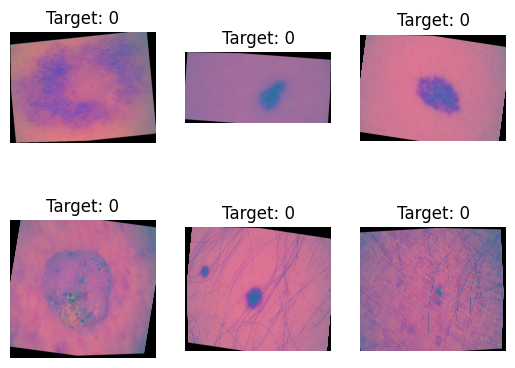

In [ ]:
import matplotlib.pyplot as plt

for i in range(6):
    plt.subplot(2, 3, i + 1)  # 2 rows of 3 images each
    image = np.array(image_aug[i])
    plt.imshow(image)  # Use cmap='gray' for grayscale images. Omit for color images.
    plt.title("Target: " + str(image_target[i]))
    plt.axis('off')  # To not show axis values

plt.show()

###IMAGES AFTER CROPPING

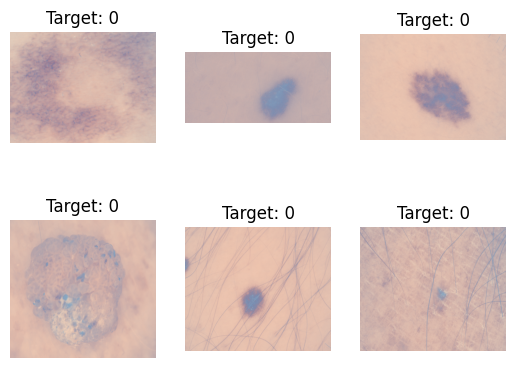

In [ ]:
import matplotlib.pyplot as plt

# Assume that 'images' is your N x H x W (or N x H x W x C) numpy array
# And 'targets' is your N x 1 numpy array with target values

for i in range(6):
    plt.subplot(2, 3, i + 1)  # 2 rows of 3 images each
    image = np.array(image_crop[i])
    plt.imshow(image)  # Use cmap='gray' for grayscale images. Omit for color images.
    plt.title("Target: " + str(image_target[i]))
    plt.axis('off')  # To not show axis values

plt.show()

###IMAGES AFTER RESIZING TO 224 * 224

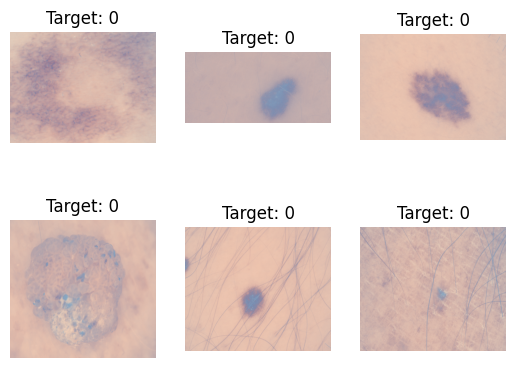

In [ ]:
import matplotlib.pyplot as plt

# Assume that 'images' is your N x H x W (or N x H x W x C) numpy array
# And 'targets' is your N x 1 numpy array with target values

for i in range(6):
    plt.subplot(2, 3, i + 1)  # 2 rows of 3 images each
    image = image_resize[i]
    plt.imshow(image)  # Use cmap='gray' for grayscale images. Omit for color images.
    plt.title("Target: " + str(image_target[i]))
    plt.axis('off')  # To not show axis values

plt.show()

###IMAGES AFTER PADDING

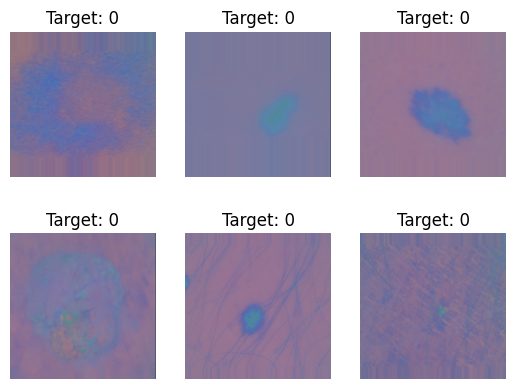

In [ ]:
import matplotlib.pyplot as plt

# Assume that 'images' is your N x H x W (or N x H x W x C) numpy array
# And 'targets' is your N x 1 numpy array with target values

for i in range(6):
    plt.subplot(2, 3, i + 1)  # 2 rows of 3 images each
    image = np.array(image_pad[i])[:,:,:]
    plt.imshow(image)  # Use cmap='gray' for grayscale images. Omit for color images.
    plt.title("Target: " + str(image_target[i]))
    plt.axis('off')  # To not show axis values

plt.show()

###VISUALIZING THE IMAGES

In [ ]:
show_image(image_pad[0])

###USING DIFFERENT AUGMENTATION

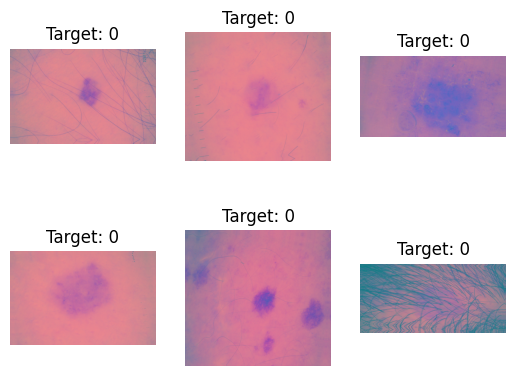

In [ ]:
import matplotlib.pyplot as plt

# Assume that 'images' is your N x H x W (or N x H x W x C) numpy array
# And 'targets' is your N x 1 numpy array with target values

for i in range(6):
    plt.subplot(2, 3, i + 1)  # 2 rows of 3 images each
    image = np.array(image_aug2[i])
    plt.imshow(image)  # Use cmap='gray' for grayscale images. Omit for color images.
    plt.title("Target: " + str(image_target2[i]))
    plt.axis('off')  # To not show axis values

plt.show()

###IMAGES AFTER RESIZING

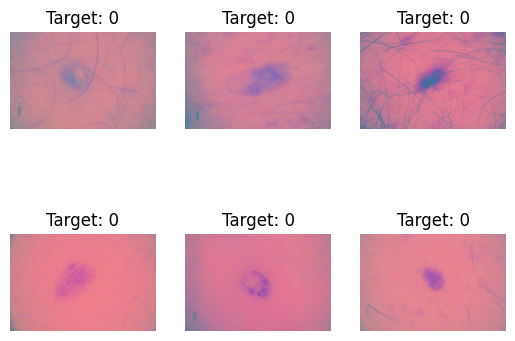

In [ ]:
import matplotlib.pyplot as plt

# Assume that 'images' is your N x H x W (or N x H x W x C) numpy array
# And 'targets' is your N x 1 numpy array with target values

for i in range(6):
    plt.subplot(2, 3, i + 1)  # 2 rows of 3 images each
    image = np.array(image_resize2[i])
    plt.imshow(image)  # Use cmap='gray' for grayscale images. Omit for color images.
    plt.title("Target: " + str(image_target2[i]))
    plt.axis('off')  # To not show axis values

plt.show()

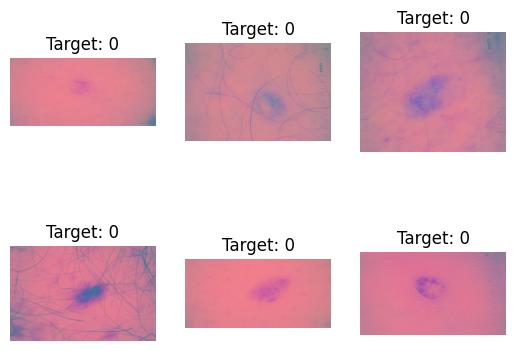

In [ ]:
import matplotlib.pyplot as plt

# Assume that 'images' is your N x H x W (or N x H x W x C) numpy array
# And 'targets' is your N x 1 numpy array with target values

for i in range(6):
    plt.subplot(2, 3, i + 1)  # 2 rows of 3 images each
    image = np.array(image_aug2[i])
    plt.imshow(image)  # Use cmap='gray' for grayscale images. Omit for color images.
    plt.title("Target: " + str(image_target2[i]))
    plt.axis('off')  # To not show axis values

plt.show()

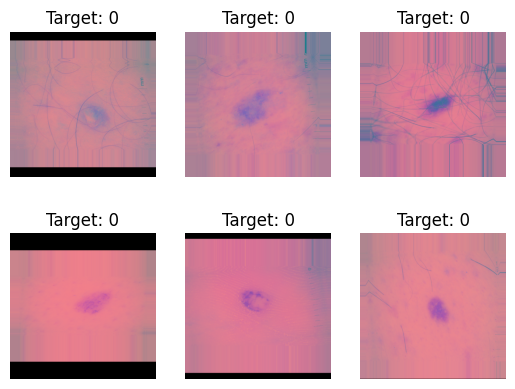

In [ ]:
import matplotlib.pyplot as plt

# Assume that 'images' is your N x H x W (or N x H x W x C) numpy array
# And 'targets' is your N x 1 numpy array with target values

for i in range(6):
    plt.subplot(2, 3, i + 1)  # 2 rows of 3 images each
    image = np.array(image_pad2[i])
    plt.imshow(image)  # Use cmap='gray' for grayscale images. Omit for color images.
    plt.title("Target: " + str(image_target2[i]))
    plt.axis('off')  # To not show axis values

plt.show()

###USING CV2 TO SHOW IMAGES IN ORIGINAL COLOUR AFTER PREPROCESSING

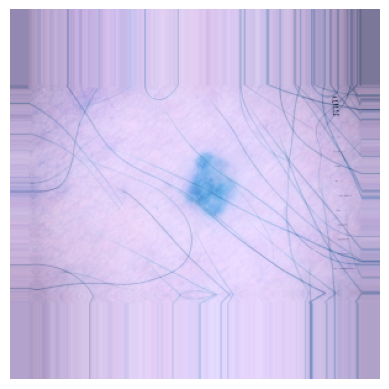

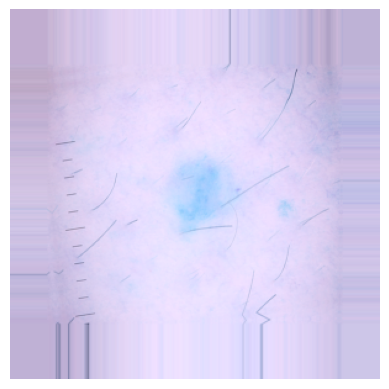

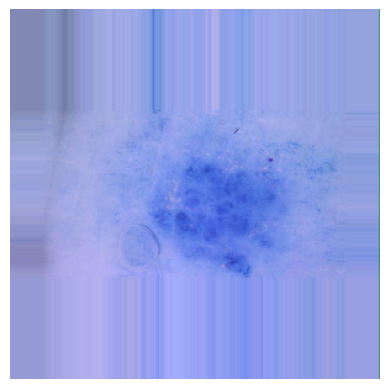

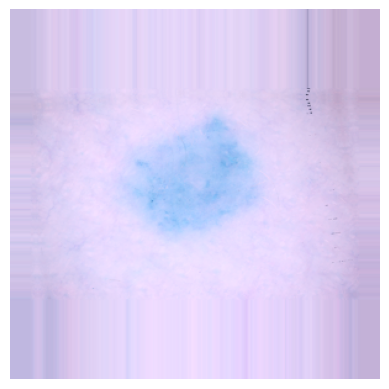

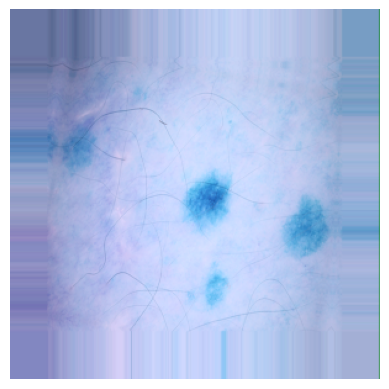

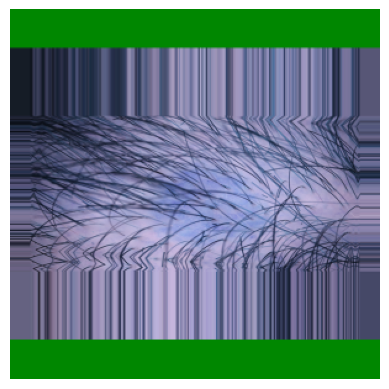

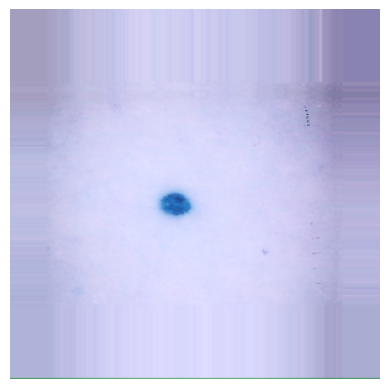

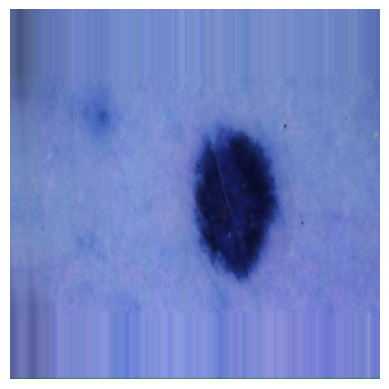

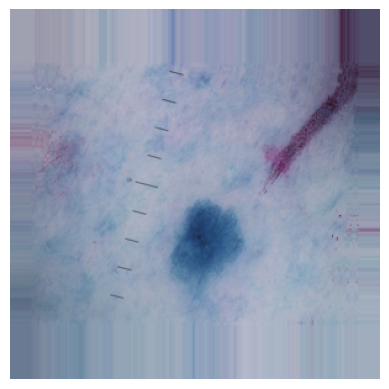

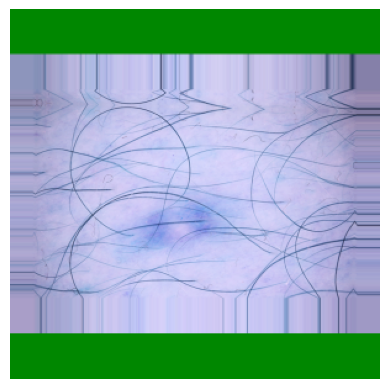

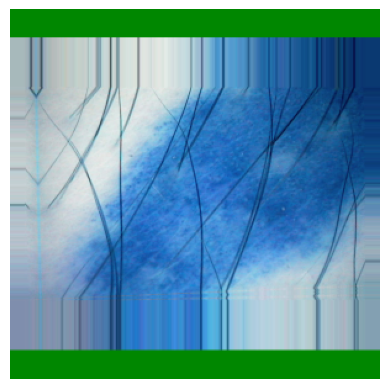

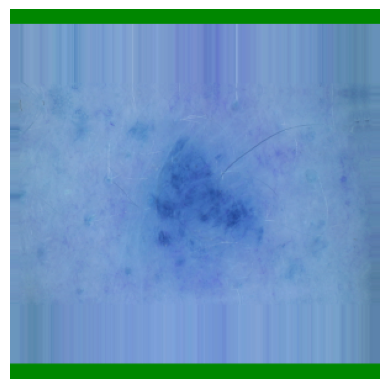

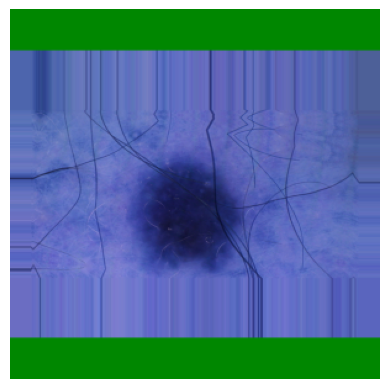

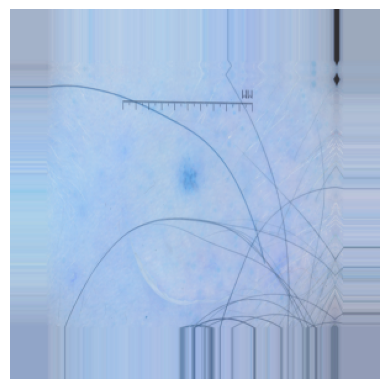

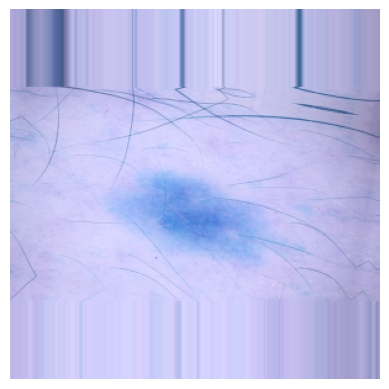

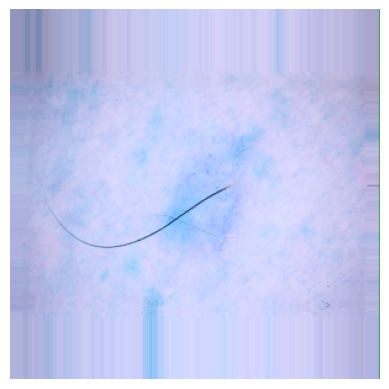

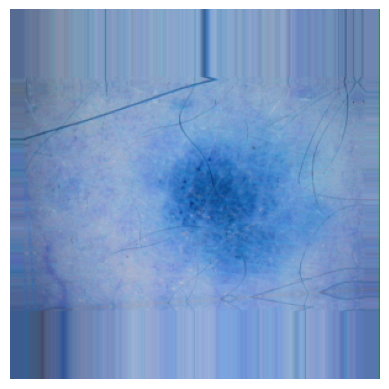

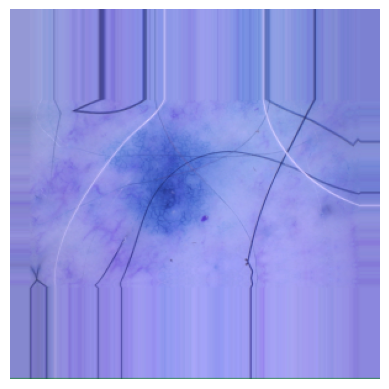

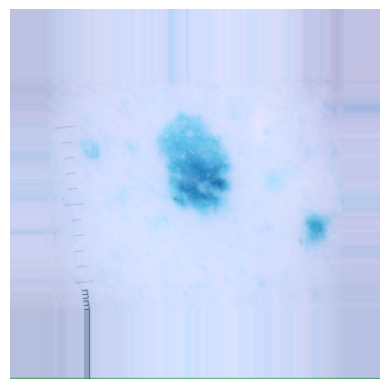

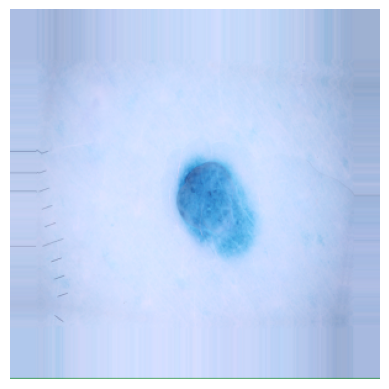

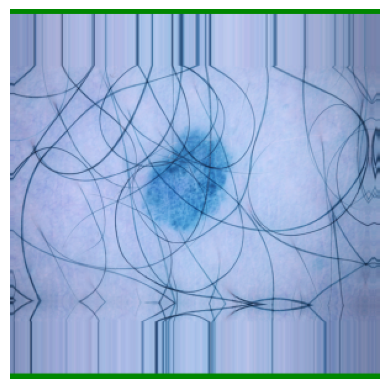

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'image' is correctly defined
for i in image_pad2:
  image = cv2.cvtColor(np.array(i), cv2.COLOR_YCrCb2RGB)
  height, width = image.shape[:2]
  zoomout_factor = 0.5  # Assuming a zoomout_factor, adjust this value as per your need
  zoomed_width = int(width * zoomout_factor)
  zoomed_height = int(height * zoomout_factor)
  zoomed_image = cv2.resize(image, (zoomed_width, zoomed_height))

  # Using Matplotlib to show the image
  plt.imshow(zoomed_image)
  plt.axis('off')  # To not show axis values
  plt.show()

#CODE FOR TRAINING & TESTING THE DEEP LEARNING MODELS

###Importing the libraries

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import utils
from tensorflow.keras.models import save_model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Accuracy, Precision, Recall, CategoricalAccuracy
from tensorflow.keras.optimizers.schedules import CosineDecay
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import DenseNet201

###Custom Callback for printing loss and accuracy

In [ ]:
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("End of epoch: ", epoch)
        print("Train loss: ", logs['loss'])
        print("Train accuracy: ", logs['accuracy'])

###Tracking the precision, recall, sensitivity & specitivity for the model

In [ ]:
# Custom Callback to calculate sensitivity and specificity after each epoch
class SensitivitySpecificityCallback(Callback):
    def on_train_begin(self, logs={}):
        self.metrics_dict = {
            'accuracy': [],
            'precision': [],
            'recall': [],
            'sensitivity': [],
            'specificity': []
        }

    def __init__(self, validation_data):
        super(SensitivitySpecificityCallback, self).__init__()
        self.validation_data = validation_data

    # other methods ...

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val_one_hot = self.validation_data
        y_pred = np.argmax(self.model.predict(X_val), axis=1)

        # Convert one-hot encoded y_val to class indices
        y_val = np.argmax(y_val_one_hot, axis=1)

        tp = sum((y_val == 1) & (y_pred == 1))
        tn = sum((y_val == 0) & (y_pred == 0))
        fp = sum((y_val == 0) & (y_pred == 1))
        fn = sum((y_val == 1) & (y_pred == 0))

        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        self.metrics_dict['accuracy'].append(logs.get('accuracy'))
        self.metrics_dict['precision'].append(logs.get('precision'))
        self.metrics_dict['recall'].append(logs.get('recall'))
        self.metrics_dict['sensitivity'].append(sensitivity)
        self.metrics_dict['specificity'].append(specificity)

###Data Generator class to import data in batches to not overload the ram

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    'Generates data for Keras'
    def __init__(self, list_IDs, labels, img_dir, batch_size=32, dim=(224,224), n_channels=3,
             n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.data_path = img_dir  # Where to load images from
        self.on_epoch_end()  # Call this at the end of the initialization


    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Load the data using memory-mapping
        mmap = np.load(self.data_path, mmap_mode='r')

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = mmap[int(ID),]

            # Store class
            y[i] = self.labels[ID]

        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

def create_partition_and_labels(X, y):
    # Generate ID-label mappings
    ids = range(len(X))
    labels = {str(i): y[i] for i in ids}

    # Create partition dictionary
    partition = {'train': [str(i) for i in ids]}

    return partition, labels

###Saving Metrics Dictionary in Drive

In [ ]:
import pickle

def remove_metric_index(history_dict):
    new_dict = {}
    for key, value in history_dict.items():
        new_key = ''.join([i for i in key if not i.isdigit()])
        new_dict[new_key] = value
    return new_dict

def save_history_dict(history, name):
  history_dict = remove_metric_index(history.history)

  try:
    # Create a dictionary from the history
    history_dict = {
        'accuracy': history_dict['categorical_accuracy'],
        'val_accuracy': history_dict['val_categorical_accuracy'],  # if validation data was provided during training
        'loss': history_dict['loss'],
        'val_loss': history_dict['val_loss'],  # if validation data was provided during training
        'precision': history_dict['precision_'],
        'val_precision': history_dict['val_precision_'],  # if validation data was provided during training
        'recall': history_dict['recall_'],
        'val_recall': history_dict['val_recall_'],  # if validation data was provided during training
        'sensitivity': metrics_callback.metrics_dict['sensitivity'],
        'specificity': metrics_callback.metrics_dict['specificity']
    }
  except:
    # Create a dictionary from the history
    history_dict = {
        'accuracy': history_dict['categorical_accuracy'],
        'val_accuracy': history_dict['val_categorical_accuracy'],  # if validation data was provided during training
        'loss': history_dict['loss'],
        'val_loss': history_dict['val_loss'],  # if validation data was provided during training
        'precision': history_dict['precision'],
        'val_precision': history_dict['val_precision'],  # if validation data was provided during training
        'recall': history_dict['recall'],
        'val_recall': history_dict['val_recall'],  # if validation data was provided during training
        'sensitivity': metrics_callback.metrics_dict['sensitivity'],
        'specificity': metrics_callback.metrics_dict['specificity']
    }
  # Save the dictionary
  with open('drive/MyDrive/skin cancer data/'+name+'.pickle', 'wb') as f:
      pickle.dump(history_dict, f)

###EfficientNet b6 Code with pretrained Imagenet Weights

In [ ]:
# Instantiate the custom callback
custom_callback = CustomCallback()

# Import your data with allow_pickle=True
X_train = np.load('drive/MyDrive/skin cancer data/X_test.npy', allow_pickle=True)
y_train = np.load('drive/MyDrive/skin cancer data/y_test.npy', allow_pickle=True)

# Normalizing pixel values
X_train = preprocess_input(X_train)
y_train = utils.to_categorical(y_train)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

###Compiling & Training the model

In [ ]:
metrics_callback = SensitivitySpecificityCallback((X_val, y_val))

# Define the number of training samples and batch size
num_train_samples = X_train.shape[0]
batch_size = 16  # New batch size
number_of_epochs = 40  # Number of epochs

# Define initial learning rate and total steps, and then instantiate a CosineDecay scheduler
initial_learning_rate = 0.00001
lr_schedule = CosineDecay(
    initial_learning_rate, decay_steps=int(np.ceil(num_train_samples / batch_size) * number_of_epochs), alpha=0.0)

# Instantiate a base model with pre-trained weights.
base_model = EfficientNetB6(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(600, 600, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top.
inputs = layers.Input(shape=(600, 600, 3))
x = base_model(inputs, training=False)

# Add a new top layer which will be trained
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(2, activation='softmax')(x)  # Replace <number_of_classes> with your actual number of classes
model = models.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss= CategoricalCrossentropy(),
              metrics=[CategoricalAccuracy(), Precision(), Recall()])

# Train the model
history = model.fit(X_train, y_train, epochs=number_of_epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val), callbacks=[metrics_callback])

tf.saved_model.save(model, 'efficientnetb6_model_with_weights_600')

165234480/165234480 [==============================] - 10s 0us/step
Epoch 1/40
165/165 [==============================] - 224s 1s/step - loss: 0.7160 - categorical_accuracy: 0.4769 - precision_1: 0.4769 - recall_1: 0.4769 - val_loss: 0.7044 - val_categorical_accuracy: 0.4676 - val_precision_1: 0.4676 - val_recall_1: 0.4676
Epoch 2/40
165/165 [==============================] - 184s 1s/step - loss: 0.6908 - categorical_accuracy: 0.5349 - precision_1: 0.5349 - recall_1: 0.5349 - val_loss: 0.6854 - val_categorical_accuracy: 0.5256 - val_precision_1: 0.5256 - val_recall_1: 0.5256
Epoch 3/40
165/165 [==============================] - 184s 1s/step - loss: 0.6739 - categorical_accuracy: 0.6191 - precision_1: 0.6191 - recall_1: 0.6191 - val_loss: 0.6696 - val_categorical_accuracy: 0.6212 - val_precision_1: 0.6212 - val_recall_1: 0.6212
Epoch 4/40
165/165 [==============================] - 184s 1s/step - loss: 0.6593 - categorical_accuracy: 0.6673 - precision_1: 0.6673 - recall_1: 0.6673 - val_l

In [ ]:
save_history_dict(history, 'metrics_efficientnetb6_model_with_weights_600_dict')

In [ ]:
import pickle
with open('drive/MyDrive/skin cancer data/metrics_efficientnetb6_model_with_weights_600_dict.pickle', 'rb') as f:
    loaded_history_dict = pickle.load(f)
loaded_history_dict

###VGG 19 with pretrained Imagenet Weights

In [ ]:
# Instantiate the custom callback
custom_callback = CustomCallback()

# Load your data
X_train = np.load('drive/MyDrive/skin cancer data/data/X_train_224.npy', allow_pickle=True, mmap_mode='r')
y_train = np.load('drive/MyDrive/skin cancer data/data/y_train.npy', allow_pickle=True, mmap_mode='r')

# Create partition and labels for training set
partition_train, labels_train = create_partition_and_labels(X_train, y_train)

# Load your validation data
X_val = np.load('drive/MyDrive/skin cancer data/data/X_val_224.npy', allow_pickle=True, mmap_mode='r')
y_val = np.load('drive/MyDrive/skin cancer data/data/y_val.npy', allow_pickle=True, mmap_mode='r')

# Create partition and labels for validation set
partition_val, labels_val = create_partition_and_labels(X_val, y_val)

# Parameters
params = {'dim': (224,224),
          'batch_size': 64,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True}

# Generators
training_generator = DataGenerator(partition_train['train'], labels_train, 'drive/MyDrive/skin cancer data/data/X_train_224.npy', **params)
validation_generator = DataGenerator(partition_val['train'], labels_val, 'drive/MyDrive/skin cancer data/data/X_val_224.npy', **params)

In [ ]:
del X_train, partition_train, X_val, partition_val

###Compiling & Training the model

In [ ]:
metrics_callback = SensitivitySpecificityCallback(validation_generator)

# Define the number of training samples and batch size
num_train_samples = len(training_generator) * training_generator.batch_size
batch_size = 8  # New batch size
number_of_epochs = 10  # Number of epochs

# Define initial learning rate and total steps, and then instantiate a CosineDecay scheduler
initial_learning_rate = 0.0001
lr_schedule = CosineDecay(
    initial_learning_rate, decay_steps=int(np.ceil(num_train_samples / batch_size) * number_of_epochs), alpha=0.0)

# Instantiate a base model with pre-trained weights.
base_model = VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top.
inputs = layers.Input(shape=(224, 224, 3))  # VGG19 uses input images of size 224x224
x = base_model(inputs, training=False)

# Add a new top layer which will be trained
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(2, activation='softmax')(x)  # Replace <number_of_classes> with your actual number of classes
model = models.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss= CategoricalCrossentropy(),
              metrics=[CategoricalAccuracy(), Precision(), Recall()])

80134624/80134624 [==============================] - 5s 0us/step


In [ ]:
# Use the generators in the fit function
history = model.fit(training_generator, epochs=number_of_epochs, validation_data=validation_generator, callbacks=[metrics_callback])
model.save('drive/MyDrive/skin cancer data/weights/vgg19_model')

Epoch 1/10
711/711 [==============================] - 1402s 2s/step - loss: 0.7138 - categorical_accuracy: 0.5243 - precision: 0.5243 - recall: 0.5243 - val_loss: 0.6785 - val_categorical_accuracy: 0.6727 - val_precision: 0.6727 - val_recall: 0.6727
Epoch 2/10
711/711 [==============================] - 934s 1s/step - loss: 0.6649 - categorical_accuracy: 0.6447 - precision: 0.6447 - recall: 0.6447 - val_loss: 0.6532 - val_categorical_accuracy: 0.6624 - val_precision: 0.6624 - val_recall: 0.6624
Epoch 3/10
711/711 [==============================] - 1054s 1s/step - loss: 0.6429 - categorical_accuracy: 0.6639 - precision: 0.6639 - recall: 0.6639 - val_loss: 0.6342 - val_categorical_accuracy: 0.6651 - val_precision: 0.6651 - val_recall: 0.6651
Epoch 4/10
711/711 [==============================] - 959s 1s/step - loss: 0.6254 - categorical_accuracy: 0.6807 - precision: 0.6807 - recall: 0.6807 - val_loss: 0.6191 - val_categorical_accuracy: 0.6707 - val_precision: 0.6707 - val_recall: 0.6707
Ep

In [ ]:
# Load the model
loaded_model = models.load_model('drive/MyDrive/skin cancer data/weights/vgg19_model_adam_full_dataset_final')

# You can continue training using the loaded model.
# Note: You may need to compile the model again before training.
loaded_model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
                     loss=CategoricalCrossentropy(),
                     metrics=[CategoricalAccuracy(), Precision(), Recall()])

# Continue training
history = loaded_model.fit(training_generator, epochs=10,
                           validation_data=validation_generator,
                           callbacks=[metrics_callback])

loaded_model.save('drive/MyDrive/skin cancer data/weights/vgg19_model_adam_full_dataset_final_2')

Epoch 1/10
711/711 [==============================] - 932s 1s/step - loss: 0.4608 - categorical_accuracy: 0.7999 - precision_1: 0.7999 - recall_1: 0.7999 - val_loss: 0.4622 - val_categorical_accuracy: 0.7966 - val_precision_1: 0.7966 - val_recall_1: 0.7966
Epoch 2/10
711/711 [==============================] - 957s 1s/step - loss: 0.4592 - categorical_accuracy: 0.8007 - precision_1: 0.8007 - recall_1: 0.8007 - val_loss: 0.4603 - val_categorical_accuracy: 0.8013 - val_precision_1: 0.8013 - val_recall_1: 0.8013
Epoch 3/10
711/711 [==============================] - 954s 1s/step - loss: 0.4576 - categorical_accuracy: 0.8021 - precision_1: 0.8021 - recall_1: 0.8021 - val_loss: 0.4595 - val_categorical_accuracy: 0.7965 - val_precision_1: 0.7965 - val_recall_1: 0.7965
Epoch 4/10
711/711 [==============================] - 948s 1s/step - loss: 0.4562 - categorical_accuracy: 0.8014 - precision_1: 0.8014 - recall_1: 0.8014 - val_loss: 0.4573 - val_categorical_accuracy: 0.8022 - val_precision_1: 0.

In [ ]:
save_history_dict(history, 'metrics_vgg19_model_with_weights_224_dict_original_Adam_5')

###Predicting the classes using Test Dataset on VGG 19 Model

In [ ]:
# Load your validation data
X_test = np.load('drive/MyDrive/skin cancer data/data/X_test_224.npy', allow_pickle=True, mmap_mode='r')
y_test = np.load('drive/MyDrive/skin cancer data/data/y_test.npy', allow_pickle=True, mmap_mode='r')

# Create partition and labels for validation set
partition_test, labels_test = create_partition_and_labels(X_test, y_test)

# Parameters
params = {'dim': (224,224),
          'batch_size': 64,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True}

test_generator = DataGenerator(partition_test['test'], labels_test, 'drive/MyDrive/skin cancer data/data/X_test_224.npy', **params)

# Predict on the test data
predictions = model.predict(test_generator)

# Get the class with the highest probability for each sample
predictions_classes = np.argmax(predictions, axis=-1)

# Save the predictions to a numpy array
np.save('drive/MyDrive/skin cancer data/data/vgg19_predictions_classes_original.npy', predictions_classes)
# Save the probabilities for each class to a numpy array
np.save('drive/MyDrive/skin cancer data/data/vgg19_predictions_original.npy', predictions)


###Using Densenet 201 with pretrainined Imagenet Weights

In [ ]:
# Instantiate the custom callback
custom_callback = CustomCallback()

In [ ]:
# Load your data
X_train = np.load('drive/MyDrive/skin cancer data/data/X_train_224.npy', allow_pickle=True, mmap_mode='r')
y_train = np.load('drive/MyDrive/skin cancer data/data/y_train.npy', allow_pickle=True, mmap_mode='r')

# Create partition and labels for training set
partition_train, labels_train = create_partition_and_labels(X_train, y_train)

# Load your validation data
X_val = np.load('drive/MyDrive/skin cancer data/data/X_val_224.npy', allow_pickle=True, mmap_mode='r')
y_val = np.load('drive/MyDrive/skin cancer data/data/y_val.npy', allow_pickle=True, mmap_mode='r')

# Create partition and labels for validation set
partition_val, labels_val = create_partition_and_labels(X_val, y_val)

# Parameters
params = {'dim': (224,224),
          'batch_size': 64,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True}

# Generators
training_generator = DataGenerator(partition_train['train'], labels_train, 'drive/MyDrive/skin cancer data/data/X_train_224.npy', **params)
validation_generator = DataGenerator(partition_val['train'], labels_val, 'drive/MyDrive/skin cancer data/data/X_val_224.npy', **params)


In [ ]:
del X_train, partition_train, X_val, partition_val

###Compiling and Training using Densenet 201

In [ ]:
metrics_callback = SensitivitySpecificityCallback(validation_generator)

# Define the number of training samples and batch size
num_train_samples = len(training_generator) * training_generator.batch_size
batch_size = 8  # New batch size
number_of_epochs = 10  # Number of epochs

# Define initial learning rate and total steps, and then instantiate a CosineDecay scheduler
initial_learning_rate = 0.0001
lr_schedule = CosineDecay(
    initial_learning_rate, decay_steps=int(np.ceil(num_train_samples / batch_size) * number_of_epochs), alpha=0.0)

# Instantiate a base model with pre-trained weights.
base_model = DenseNet201(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top.
inputs = layers.Input(shape=(224, 224, 3))  # VGG19 uses input images of size 224x224
x = base_model(inputs, training=False)

# Add a new top layer which will be trained
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(2, activation='softmax')(x)  # Replace <number_of_classes> with your actual number of classes
model = models.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss= CategoricalCrossentropy(),
              metrics=[CategoricalAccuracy(), Precision(), Recall()])

# Use the generators in the fit function
history = model.fit(training_generator, epochs=number_of_epochs, validation_data=validation_generator, callbacks=[metrics_callback])

# Save the model
tf.saved_model.save(model, 'drive/MyDrive/skin cancer data/vgg19_model_with_weights_original_dataset')

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
model.save('drive/MyDrive/skin cancer data/weights/densenet201_model')

In [ ]:
# Load the model
loaded_model = models.load_model('drive/MyDrive/skin cancer data/weights/densenet201_model')

# You can continue training using the loaded model.
# Note: You may need to compile the model again before training.
loaded_model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
                     loss=CategoricalCrossentropy(),
                     metrics=[CategoricalAccuracy(), Precision(), Recall()])

# Continue training
history2 = loaded_model.fit(training_generator, epochs=10,
                           validation_data=validation_generator,
                           callbacks=[metrics_callback])

loaded_model.save('drive/MyDrive/skin cancer data/weights/densenet201_model')

Epoch 1/10
711/711 [==============================] - 935s 1s/step - loss: 0.3119 - categorical_accuracy: 0.8761 - precision_3: 0.8761 - recall_3: 0.8761 - val_loss: 0.3129 - val_categorical_accuracy: 0.8759 - val_precision_3: 0.8759 - val_recall_3: 0.8759
Epoch 2/10
711/711 [==============================] - 956s 1s/step - loss: 0.3057 - categorical_accuracy: 0.8799 - precision_3: 0.8799 - recall_3: 0.8799 - val_loss: 0.3075 - val_categorical_accuracy: 0.8772 - val_precision_3: 0.8772 - val_recall_3: 0.8772
Epoch 3/10
711/711 [==============================] - 938s 1s/step - loss: 0.3003 - categorical_accuracy: 0.8822 - precision_3: 0.8822 - recall_3: 0.8822 - val_loss: 0.3029 - val_categorical_accuracy: 0.8798 - val_precision_3: 0.8798 - val_recall_3: 0.8798
Epoch 4/10
711/711 [==============================] - 911s 1s/step - loss: 0.2952 - categorical_accuracy: 0.8843 - precision_3: 0.8843 - recall_3: 0.8843 - val_loss: 0.3009 - val_categorical_accuracy: 0.8820 - val_precision_3: 0.

In [ ]:
# Use the generators in the fit function
history = model.fit(training_generator, epochs=number_of_epochs, validation_data=validation_generator, callbac
                    ks=[metrics_callback])
# Save the model
tf.saved_model.save(model, 'drive/MyDrive/skin cancer data/data/Densenet_model_with_weights_original_dataset')

In [ ]:
save_history_dict(history, 'metrics_desenet_model_with_weights_224_dict_original_2')

###Densenet 201 prediction on Test Dataset

In [ ]:
# Load your validation data
X_test = np.load('drive/MyDrive/skin cancer data/data/X_test_224.npy', allow_pickle=True, mmap_mode='r')
y_test = np.load('drive/MyDrive/skin cancer data/data/y_test.npy', allow_pickle=True, mmap_mode='r')

print(y_test)
# Create partition and labels for validation set
partition_test, labels_test = create_partition_and_labels(X_test, y_test)

# Parameters
params = {'dim': (224,224),
          'batch_size': 1,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': False}

test_generator = DataGenerator(partition_test['train'], labels_test, 'drive/MyDrive/skin cancer data/data/X_test_224.npy', **params)

# Load the model
model = models.load_model('drive/MyDrive/skin cancer data/weights/densenet201_model_new')

# Predict on the test data
predictions = model.predict(test_generator)

# Get the class with the highest probability for each sample
predictions_classes = np.argmax(predictions, axis=-1)

# Save the predictions to a numpy array
np.save('drive/MyDrive/skin cancer data/data/vgg19_predictions_classes_original.npy', predictions_classes)
# Save the probabilities for each class to a numpy array
np.save('drive/MyDrive/skin cancer data/data/vgg19_predictions_original.npy', predictions)


[1 1 1 ... 0 1 0]
2929/2929 [==============================] - 90s 26ms/step


In [ ]:
y_pred = predictions_classes
y_true = y_test

###Densenet 201 Test Results

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report

# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_true, y_pred)
print(f'Precision: {precision}')

# Recall (Sensitivity)
recall = recall_score(y_true, y_pred)
print(f'Recall: {recall}')

# Specificity
specificity = tn / (tn+fp)
print(f'Specificity: {specificity}')

# Sensitivity
sensitivity = tp / (tp+fn)
print(f'Sensitivity: {sensitivity}')

print("")

# Print the classification report
print(classification_report(y_true, y_pred))

Accuracy: 0.8910891089108911
Precision: 0.8715120051914341
Recall: 0.9173497267759563
Specificity: 0.8648464163822526
Sensitivity: 0.9173497267759563

              precision    recall  f1-score   support

           0       0.91      0.86      0.89      1465
           1       0.87      0.92      0.89      1464

    accuracy                           0.89      2929
   macro avg       0.89      0.89      0.89      2929
weighted avg       0.89      0.89      0.89      2929



In [ ]:
# Load your validation data
X_test = np.load('drive/MyDrive/skin cancer data/data/X_test_224.npy', allow_pickle=True, mmap_mode='r')
y_test = np.load('drive/MyDrive/skin cancer data/data/y_test.npy', allow_pickle=True, mmap_mode='r')

print(y_test)
# Create partition and labels for validation set
partition_test, labels_test = create_partition_and_labels(X_test, y_test)

# Parameters
params = {'dim': (224,224),
          'batch_size': 1,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': False}

test_generator = DataGenerator(partition_test['train'], labels_test, 'drive/MyDrive/skin cancer data/data/X_test_224.npy', **params)

# Load the model
model = models.load_model('drive/MyDrive/skin cancer data/weights/vgg19_model_adam_full_dataset_final')

# Predict on the test data
predictions = model.predict(test_generator)

# Get the class with the highest probability for each sample
predictions_classes = np.argmax(predictions, axis=-1)

[1 1 1 ... 0 1 0]
2929/2929 [==============================] - 33s 11ms/step


In [ ]:
y_pred = predictions_classes
y_true = y_test

###VGG 19 Test Results

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
# Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_true, y_pred)
print(f'Precision: {precision}')

# Recall (Sensitivity)
recall = recall_score(y_true, y_pred)
print(f'Recall: {recall}')

# Specificity
specificity = tn / (tn+fp)
print(f'Specificity: {specificity}')

# Sensitivity
sensitivity = tp / (tp+fn)
print(f'Sensitivity: {sensitivity}')

print("")

# Print the classification report
print(classification_report(y_true, y_pred))

Accuracy: 0.801297371116422
Precision: 0.8033012379642366
Recall: 0.7978142076502732
Specificity: 0.8047781569965871
Sensitivity: 0.7978142076502732

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1465
           1       0.80      0.80      0.80      1464

    accuracy                           0.80      2929
   macro avg       0.80      0.80      0.80      2929
weighted avg       0.80      0.80      0.80      2929



###Ensembling VGG19 & DENSENET 201 Models using Averaging the predictions and choosing the highest one

In [ ]:
from tensorflow.keras import models
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report

# Load the models
densenet_model = models.load_model('drive/MyDrive/skin cancer data/weights/densenet201_model_new')
vgg19_model = models.load_model('drive/MyDrive/skin cancer data/weights/vgg19_model_adam_full_dataset_final')

# Generate predictions
densenet_predictions = densenet_model.predict(test_generator)
vgg19_predictions = vgg19_model.predict(test_generator)

# Average the predictions
average_predictions = (densenet_predictions + vgg19_predictions) / 2

# Get the class with the highest average probability
average_predictions_classes = np.argmax(average_predictions, axis=-1)

# Evaluate the ensemble
accuracy = accuracy_score(y_test, average_predictions_classes)
precision = precision_score(y_test, average_predictions_classes)
recall = recall_score(y_test, average_predictions_classes)
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)

print(f'Ensemble Sensitivity: {sensitivity}')
print(f'Ensemble Accuracy: {accuracy}')
print(f'Ensemble Precision: {precision}')
print(f'Ensemble Recall: {recall}')
print(f'Ensemble Specificity: {specificity}')

print("")

# Print the classification report
print(classification_report(y_test, average_predictions_classes))

2929/2929 [==============================] - 31s 11ms/step
Ensemble Sensitivity: 0.7978142076502732
Ensemble Accuracy: 0.8839194264254011
Ensemble Precision: 0.8607188703465982
Ensemble Recall: 0.9159836065573771
Ensemble Specificity: 0.8047781569965871

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1465
           1       0.80      0.80      0.80      1464

    accuracy                           0.80      2929
   macro avg       0.80      0.80      0.80      2929
weighted avg       0.80      0.80      0.80      2929



In [ ]:
print(classification_report(y_test, average_predictions_classes))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1465
           1       0.86      0.92      0.89      1464

    accuracy                           0.88      2929
   macro avg       0.89      0.88      0.88      2929
weighted avg       0.89      0.88      0.88      2929



###Ensembling VGG19 & DENSENET 201 Models using Mode of the predictions and choosing the highest one

In [ ]:
# Generate class predictions
densenet_class_predictions = np.argmax(densenet_model.predict(test_generator), axis=-1)
vgg19_class_predictions = np.argmax(vgg19_model.predict(test_generator), axis=-1)

# Stack the predictions from both models
stacked_predictions = np.column_stack((densenet_class_predictions, vgg19_class_predictions))

# Use mode to find the most common prediction
from scipy.stats import mode
voted_predictions = mode(stacked_predictions, axis=1)[0]

# Evaluate the ensemble
accuracy = accuracy_score(y_test, voted_predictions)
precision = precision_score(y_test, voted_predictions)
recall = recall_score(y_test, voted_predictions)
tn, fp, fn, tp = confusion_matrix(y_test, voted_predictions).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)

print(f'Ensemble Sensitivity: {sensitivity}')
print(f'Ensemble Accuracy: {accuracy}')
print(f'Ensemble Precision: {precision}')
print(f'Ensemble Recall: {recall}')
print(f'Ensemble Specificity: {specificity}')

print("")

# Print the classification report
print(classification_report(y_true, voted_predictions))

2929/2929 [==============================] - 31s 11ms/step
Ensemble Sensitivity: 0.7657103825136612
Ensemble Accuracy: 0.8381700238989416
Ensemble Precision: 0.895367412140575
Ensemble Recall: 0.7657103825136612
Ensemble Specificity: 0.910580204778157

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1465
           1       0.90      0.77      0.83      1464

    accuracy                           0.84      2929
   macro avg       0.85      0.84      0.84      2929
weighted avg       0.85      0.84      0.84      2929



<ipython-input-16-01c431f67768>:10: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  voted_predictions = mode(stacked_predictions, axis=1)[0]


###Ensembling VGG19 & DENSENET 201 Models by choosing the highest probability prediction made by both models

In [ ]:
# Set the weights based on performance
densenet_weight = 0.6  # assuming DenseNet performs better
vgg19_weight = 0.4

# Calculate the weighted predictions
weighted_predictions = (densenet_weight*densenet_predictions + vgg19_weight*vgg19_predictions)

# Get the class with the highest average probability
weighted_predictions_classes = np.argmax(weighted_predictions, axis=-1)

# Evaluate the ensemble
accuracy = accuracy_score(y_test, weighted_predictions_classes)
precision = precision_score(y_test, weighted_predictions_classes)
recall = recall_score(y_test, weighted_predictions_classes)
tn, fp, fn, tp = confusion_matrix(y_test, weighted_predictions_classes).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)

print(f'Ensemble Sensitivity: {sensitivity}')
print(f'Ensemble Accuracy: {accuracy}')
print(f'Ensemble Precision: {precision}')
print(f'Ensemble Recall: {recall}')
print(f'Ensemble Specificity: {specificity}')

print("")

# Print the classification report
print(classification_report(y_true, weighted_predictions_classes))

Ensemble Sensitivity: 0.9228142076502732
Ensemble Accuracy: 0.8907476954592011
Ensemble Precision: 0.8671373555840821
Ensemble Recall: 0.9228142076502732
Ensemble Specificity: 0.8587030716723549

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1465
           1       0.87      0.92      0.89      1464

    accuracy                           0.89      2929
   macro avg       0.89      0.89      0.89      2929
weighted avg       0.89      0.89      0.89      2929



###Ensembling VGG19 & DENSENET 201 Models using Weighted Average Prediction Method.

In [ ]:
# Set the weights based on performance
densenet_weight = 0.7  # assuming DenseNet performs better
vgg19_weight = 0.3

# Calculate the weighted predictions
weighted_predictions = (densenet_weight*densenet_predictions + vgg19_weight*vgg19_predictions)

# Get the class with the highest average probability
weighted_predictions_classes = np.argmax(weighted_predictions, axis=-1)

# Evaluate the ensemble
accuracy = accuracy_score(y_test, weighted_predictions_classes)
precision = precision_score(y_test, weighted_predictions_classes)
recall = recall_score(y_test, weighted_predictions_classes)
tn, fp, fn, tp = confusion_matrix(y_test, weighted_predictions_classes).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)

print(f'Ensemble Sensitivity: {sensitivity}')
print(f'Ensemble Accuracy: {accuracy}')
print(f'Ensemble Precision: {precision}')
print(f'Ensemble Recall: {recall}')
print(f'Ensemble Specificity: {specificity}')

print("")

# Print the classification report
print(classification_report(y_true, weighted_predictions_classes))

Ensemble Sensitivity: 0.9241803278688525
Ensemble Accuracy: 0.896551724137931
Ensemble Precision: 0.8757281553398059
Ensemble Recall: 0.9241803278688525
Ensemble Specificity: 0.8689419795221843

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1465
           1       0.88      0.92      0.90      1464

    accuracy                           0.90      2929
   macro avg       0.90      0.90      0.90      2929
weighted avg       0.90      0.90      0.90      2929



###Ensembling VGG19 & DENSENET 201 Models using Weighted Average Prediction Method.

In [ ]:
# Set the weights based on performance
densenet_weight = 0.8  # assuming DenseNet performs better
vgg19_weight = 0.2

# Calculate the weighted predictions
weighted_predictions = (densenet_weight*densenet_predictions + vgg19_weight*vgg19_predictions)

# Get the class with the highest average probability
weighted_predictions_classes = np.argmax(weighted_predictions, axis=-1)

# Evaluate the ensemble
accuracy = accuracy_score(y_test, weighted_predictions_classes)
precision = precision_score(y_test, weighted_predictions_classes)
recall = recall_score(y_test, weighted_predictions_classes)
tn, fp, fn, tp = confusion_matrix(y_test, weighted_predictions_classes).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)

print(f'Ensemble Sensitivity: {sensitivity}')
print(f'Ensemble Accuracy: {accuracy}')
print(f'Ensemble Precision: {precision}')
print(f'Ensemble Recall: {recall}')
print(f'Ensemble Specificity: {specificity}')

print("")

# Print the classification report
print(classification_report(y_true, weighted_predictions_classes))

Ensemble Sensitivity: 0.9187158469945356
Ensemble Accuracy: 0.893820416524411
Ensemble Precision: 0.8750813272608978
Ensemble Recall: 0.9187158469945356
Ensemble Specificity: 0.8689419795221843

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1465
           1       0.88      0.92      0.90      1464

    accuracy                           0.89      2929
   macro avg       0.89      0.89      0.89      2929
weighted avg       0.89      0.89      0.89      2929



###Ensembling VGG19 & DENSENET 201 Models using Weighted Average Prediction Method.

In [ ]:
# Set the weights based on performance
densenet_weight = 0.4
vgg19_weight = 0.6 # assuming Vgg19 performs better

# Calculate the weighted predictions
weighted_predictions = (densenet_weight*densenet_predictions + vgg19_weight*vgg19_predictions)

# Get the class with the highest average probability
weighted_predictions_classes = np.argmax(weighted_predictions, axis=-1)

# Evaluate the ensemble
accuracy = accuracy_score(y_test, weighted_predictions_classes)
precision = precision_score(y_test, weighted_predictions_classes)
recall = recall_score(y_test, weighted_predictions_classes)
tn, fp, fn, tp = confusion_matrix(y_test, weighted_predictions_classes).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)

print(f'Ensemble Sensitivity: {sensitivity}')
print(f'Ensemble Accuracy: {accuracy}')
print(f'Ensemble Precision: {precision}')
print(f'Ensemble Recall: {recall}')
print(f'Ensemble Specificity: {specificity}')

print("")

# Print the classification report
print(classification_report(y_true, weighted_predictions_classes))

Ensemble Sensitivity: 0.907103825136612
Ensemble Accuracy: 0.8760669170365313
Ensemble Precision: 0.8540192926045016
Ensemble Recall: 0.907103825136612
Ensemble Specificity: 0.8450511945392492

              precision    recall  f1-score   support

           0       0.90      0.85      0.87      1465
           1       0.85      0.91      0.88      1464

    accuracy                           0.88      2929
   macro avg       0.88      0.88      0.88      2929
weighted avg       0.88      0.88      0.88      2929



#Visualizing Results

###Merging dicts and showing graph of models

In [ ]:
import pickle
from pprint import pprint

# Open the pickle file and load it into a dictionary
with open('drive/MyDrive/skin cancer data/results/metrics_desenet_model_with_weights_224_dict_original_1.pickle', 'rb') as f:
    dict1 = pickle.load(f)
with open('drive/MyDrive/skin cancer data/results/metrics_desenet_model_with_weights_224_dict_original_2.pickle', 'rb') as f:
    dict2 = pickle.load(f)

result_dict_densenet = {key: dict1.get(key, []) + dict2.get(key, []) for key in set(dict1) | set(dict2)}

pprint(result_dict_densenet)

In [ ]:
import pickle
from pprint import pprint

# Open the pickle file and load it into a dictionary
with open('drive/MyDrive/skin cancer data/results/metrics_vgg19_model_with_weights_224_dict_original_Adam_2.pickle', 'rb') as f:
    dict1 = pickle.load(f)
with open('drive/MyDrive/skin cancer data/results/metrics_vgg19_model_with_weights_224_dict_original_Adam_4.pickle', 'rb') as f:
    dict2 = pickle.load(f)

result_dict_vgg = {key: dict1.get(key, []) + dict2.get(key, []) for key in set(dict1) | set(dict2)}

pprint(result_dict_vgg)

In [ ]:
import pickle
from pprint import pprint

# Open the pickle file and load it into a dictionary
with open('drive/MyDrive/skin cancer data/results/metrics_vgg19_model_with_weights_224_dict_original.pickle', 'rb') as f:
    dict1 = pickle.load(f)
with open('drive/MyDrive/skin cancer data/results/metrics_vgg19_model_with_weights_224_dict_original_1.pickle', 'rb') as f:
    dict2 = pickle.load(f)

result_dict_vgg_old = {key: dict1.get(key, []) + dict2.get(key, []) for key in set(dict1) | set(dict2)}

pprint(result_dict_vgg_old)

In [ ]:
import pickle
from pprint import pprint

# Open the pickle file and load it into a dictionary
with open('drive/MyDrive/skin cancer data/results/metrics_vgg19_model_with_weights_224_dict.pickle', 'rb') as f:
    result_dict_vgg_sgd = pickle.load(f)

pprint(result_dict_vgg_sgd)

In [ ]:
import pickle
from pprint import pprint

# Open the pickle file and load it into a dictionary
with open('drive/MyDrive/skin cancer data/results/metrics_efficientnetb6_model_with_weights_600_dict.pickle', 'rb') as f:
    result_dict_efficientnetb6 = pickle.load(f)

pprint(result_dict_efficientnetb6)

In [ ]:
import pickle
from pprint import pprint

# Open the pickle file and load it into a dictionary
with open('drive/MyDrive/skin cancer data/results/metrics_efficientnetb7_model_with_weights_600_dict.pickle', 'rb') as f:
    result_dict_efficientnetb7 = pickle.load(f)

pprint(result_dict_efficientnetb7)

###Showing Graphs of the Results

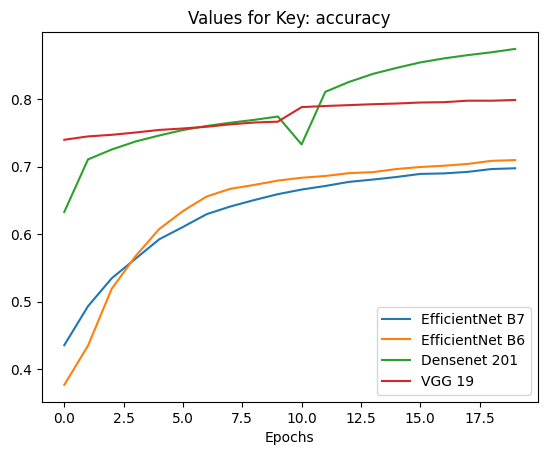

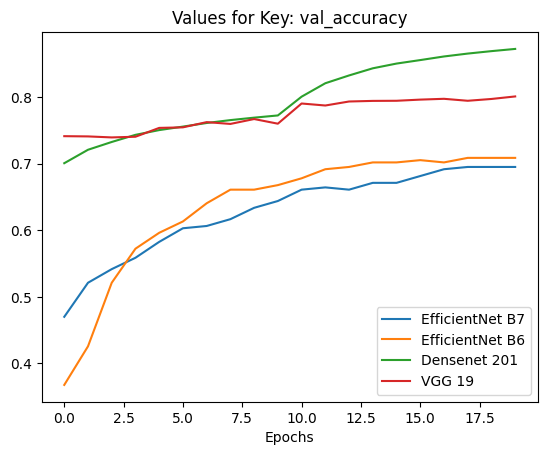

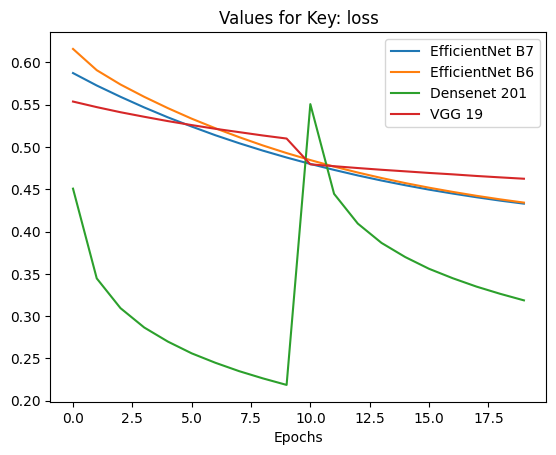

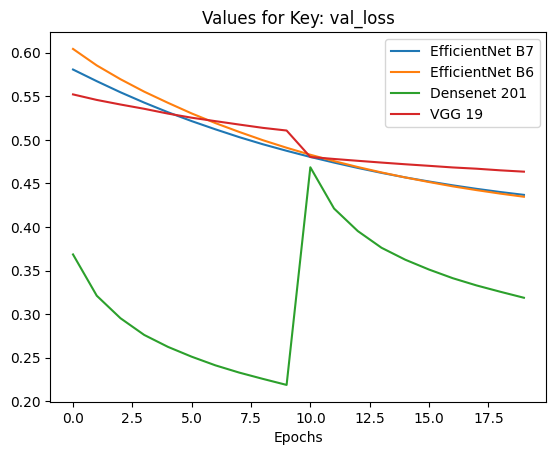

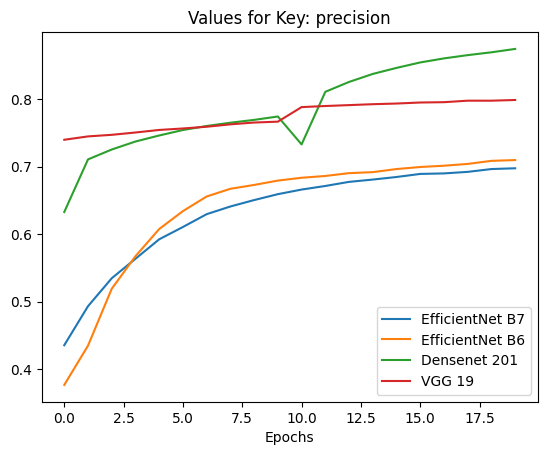

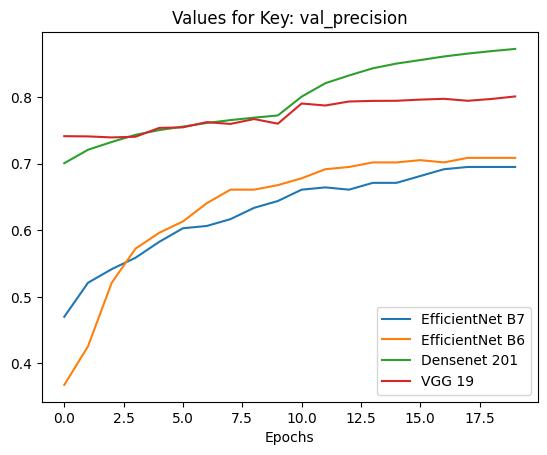

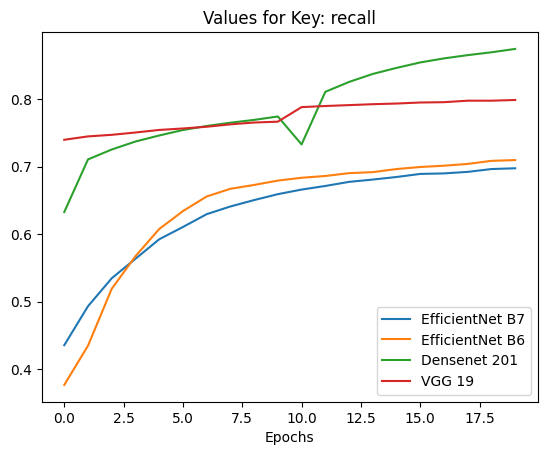

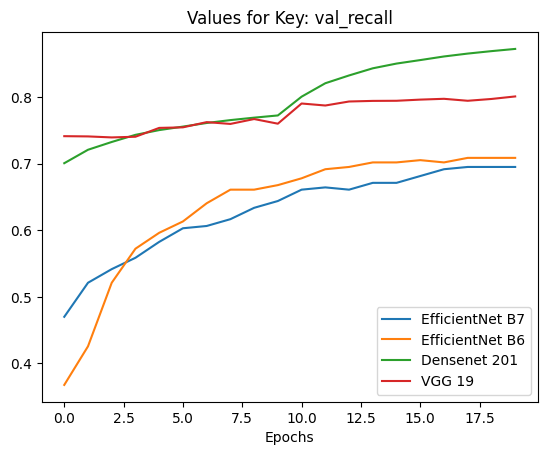

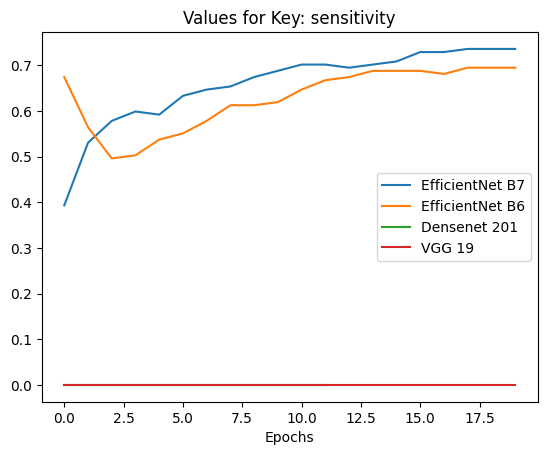

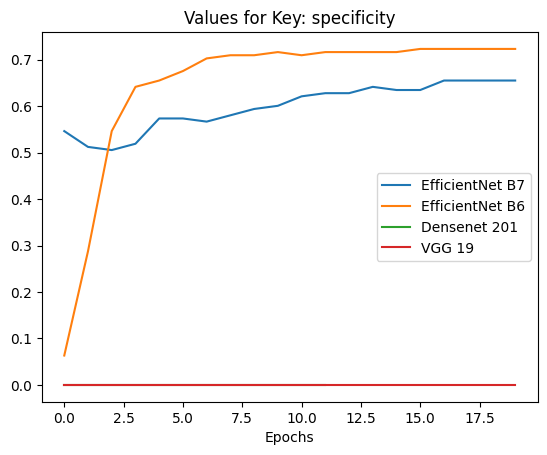

In [ ]:
import matplotlib.pyplot as plt

# Assuming that all four dictionaries have the same keys
keys = result_dict_efficientnetb7.keys()

# Iterate over each key
for key in keys:
    plt.figure()  # This creates a new figure for each key

    # Plot the values of the key for each model
    plt.plot(result_dict_efficientnetb7[key][:20], label='EfficientNet B7')
    plt.plot(result_dict_efficientnetb6[key][:20], label='EfficientNet B6')
    plt.plot(result_dict_densenet[key][:20], label='Densenet 201')
    plt.plot(result_dict_vgg[key][:20], label='VGG 19')

    # Add title and labels
    plt.title('Values for Key: ' + key)
    plt.xlabel('Epochs')
    plt.ylabel('')

    # Add legend to distinguish different models
    plt.legend()
    plt.savefig('drive/MyDrive/skin cancer data/results/{}_{}.png'.format(key, 'EfficientNet B7_B6_Densenet 201_VGG 19'))
    # Display the plot
    plt.show()

In [ ]:
for key in keys:
  print()
  print()
  print(key)
  print()
  print()
  print('efficientnetb7')
  pprint(result_dict_efficientnetb7[key][:20])
  print('efficientnetb6')
  pprint(result_dict_efficientnetb6[key][:20])
  print('densenet 201')
  pprint(result_dict_densenet[key][:20])
  print('vgg 19')
  pprint(result_dict_vgg[key][:20])